In [1]:
import os
import sys
from numba import cuda
import numpy as np
from skimage import measure as ms
import matplotlib.pyplot as plt
import math
import time

os.environ['NUMBAPRO_CUDALIB'] = (r"C:\Users\hyli93" +
                                  r"\Miniconda3\envs\py3gpu\Library\bin")

# os.environ['NUMBA_ENABLE_CUDASIM']="1"
sys.path.append('C:/Users/hyli93/Documents/GitHub/Phasing/')

import phase.gpuutil2d as gpuutil
import phase
from pyculib import fft as pfft

%matplotlib inline

# Load pattern

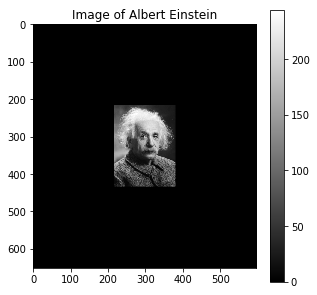

The image size is 651 by 597


In [2]:
###############################################################
# Load the pattern
###############################################################
# Read in source image
source = plt.imread(str(r'C:\Users\hyli93\Documents\GitHub' +
                        r'\Phasing\tests\samples\Albert_Einstein.jpg'),
                    format="jpg")

# Because the original image is too large downsample the image by a factor of 20
source = ms.block_reduce(source, (20, 20), np.mean)

##############################################################
# Simulate the oversampling
##############################################################
# pad_len is the size of the support
pad_len = source.shape[0]
padded = np.pad(source, ((pad_len, pad_len), (pad_len, pad_len)), 'constant',
                constant_values=((0, 0), (0, 0)))

# Show this figure
fig = plt.figure(figsize=(5, 5))
plt.imshow(padded, cmap="gray")
plt.colorbar()
plt.title("Image of Albert Einstein")
plt.show()
print("The image size is %d by %d" % (padded.shape[0], padded.shape[1]))


# Get Diffraction intensity and the mask

In [31]:
# Calculate the fourier transformation
fourier_pattern = np.fft.ifftshift(np.fft.fft2(padded))

# Get image size
length, width = padded.shape

# Get mask in real space with float value
mask_rf = np.zeros_like(padded, dtype=np.float64)
mask_rf[pad_len:2 * pad_len, pad_len:2 * pad_len] = 1

# Get mask in real space with boolean value
mask_rb = np.zeros_like(mask_rf)
mask_rb[mask_rf >= 0.5] = True

# Add beam stop effect
r_stop = 0  # Radius of the beam stop
fourier_pattern[326 - r_stop: 326 + r_stop, 299 - r_stop: 299 + r_stop] = 0

# Get mask in reciprocal space with float values
mask_if = np.ones_like(fourier_pattern, dtype=np.float64)
mask_if[326 - r_stop: 326 + r_stop, 299 - r_stop: 299 + r_stop] = 0

# Get mask in reciprocal space with boolean values
mask_ib = np.ones_like(fourier_pattern, dtype=np.bool)
mask_ib[:,:] = True
mask_ib[326 - r_stop: 326 + r_stop, 299 - r_stop: 299 + r_stop] = False

# Get the magnitude
magnitude = np.abs(fourier_pattern)


# Visualize

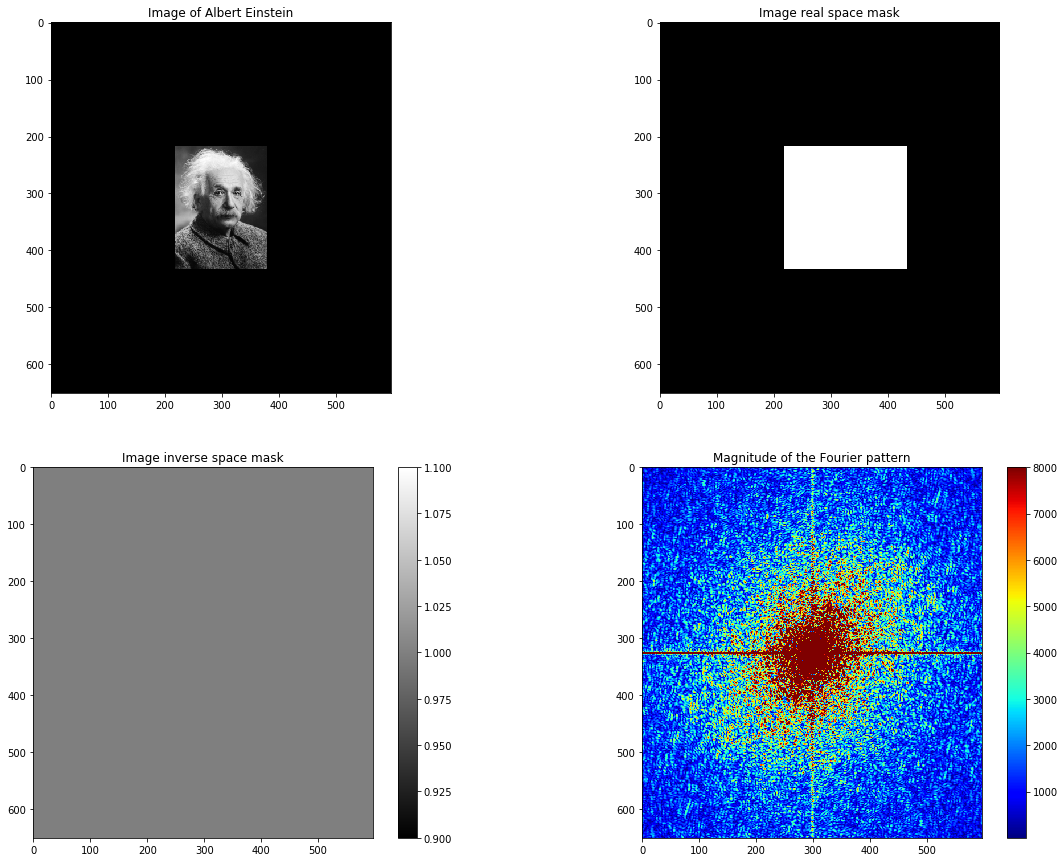

The image size is 651 by 597


In [32]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_figwidth(20)
fig.set_figheight(15)


axes[0,0].imshow(padded, cmap='gray')
axes[0,0].set_title("Image of Albert Einstein")

axes[0,1].imshow(mask_rf, cmap='gray')
axes[0,1].set_title("Image real space mask")

tmp1=axes[1,0].imshow(mask_if, cmap='gray')
axes[1,0].set_title("Image inverse space mask")

tmp = axes[1,1].imshow(magnitude, cmap='jet', vmax=8e3)
axes[1,1].set_title("Magnitude of the Fourier pattern")

fig.colorbar(mappable=tmp, ax=axes[1,1])
fig.colorbar(mappable=tmp1, ax=axes[1,0])

plt.show()
print("The image size is %d by %d" % (mask_rb.shape[0], mask_rb.shape[1]))


# Initialize the calculation
## Notice that during this process, I have finished the first step

In [33]:
# Shift the magnitude
magnitude_real = np.ascontiguousarray(np.fft.fftshift(magnitude))
magnitude_complex = np.ascontiguousarray(magnitude_real.astype(np.complex128))

# Get some pattern info
shape_0, shape_1 = magnitude.shape

# Shift the mask
mask_rb = np.ascontiguousarray(np.fft.fftshift(mask_rb))
mask_rf = np.ascontiguousarray(np.fft.fftshift(mask_rf))

# Shift the reciprocal mask
mask_ib = np.ascontiguousarray(np.fft.fftshift(mask_ib))
mask_if = np.ascontiguousarray(np.fft.fftshift(mask_if))

# magnitudeion field
phase_tmp = np.exp(1j * np.random.rand(shape_0,shape_1) * 2 * np.pi)
diffraction_complex = np.ascontiguousarray(np.multiply(magnitude_complex , phase_tmp))
diffraction_real = np.ascontiguousarray(diffraction_complex.real)

# number of iterations
r = 800

# step size parameter
beta = 0.9

# electron density
density_complex = np.ascontiguousarray(np.fft.ifft(diffraction_complex))
density_real = np.ascontiguousarray(density_complex.real)

##########################################################################################
# Define holders for intermidiate results
##########################################################################################

# Holder to store patterns modified by the real space constrain
real_holder_support_update = np.ascontiguousarray(np.ones_like(magnitude, dtype=np.float64))

# Holder to store patterns modified by the inverse space constrain
complex_holder_phase_update = np.ascontiguousarray(np.copy(diffraction_complex))

# variable to store the previous density function
"""
Notice that during this process, I have finished the first step
and have obtained a first guess of the real space density
"""
previous_density_complex = np.zeros_like(magnitude, dtype=np.complex128)
previous_density_real = np.zeros_like(magnitude, dtype=np.float64)


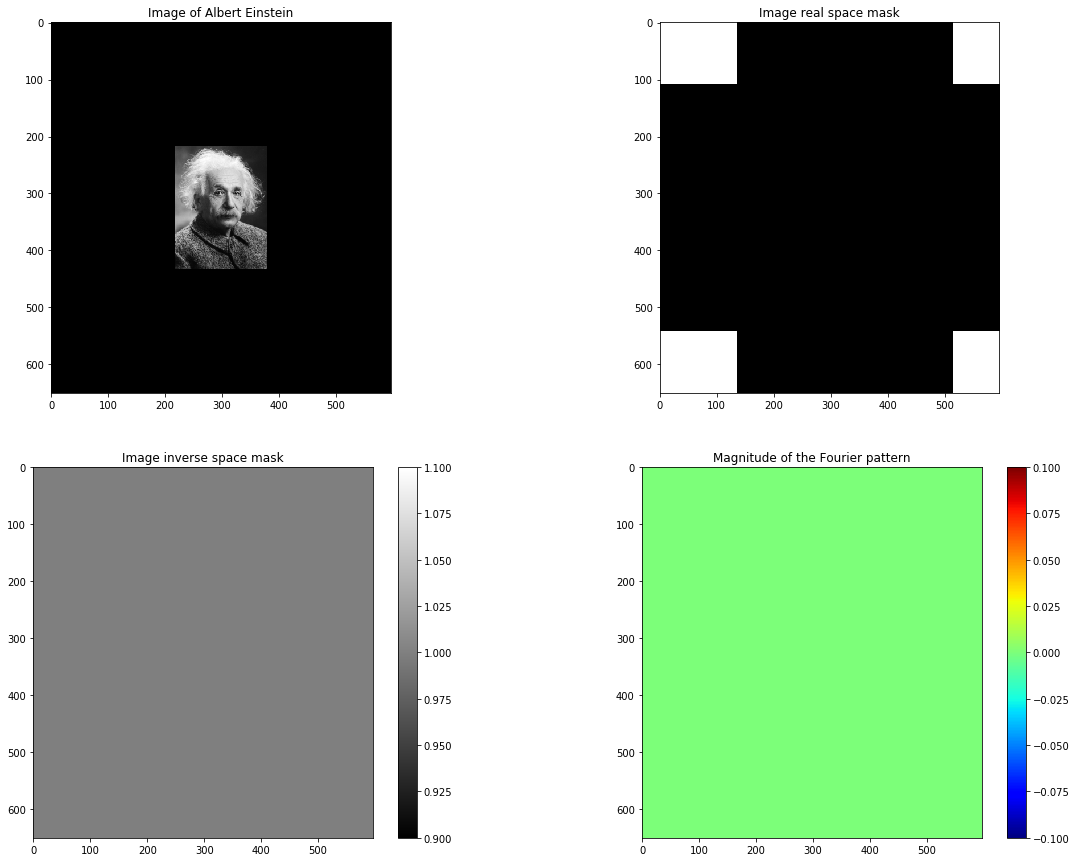

The image size is 651 by 597


In [34]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_figwidth(20)
fig.set_figheight(15)


axes[0,0].imshow(padded, cmap='gray')
axes[0,0].set_title("Image of Albert Einstein")

axes[0,1].imshow(mask_rf, cmap='gray')
axes[0,1].set_title("Image real space mask")

tmp1=axes[1,0].imshow(mask_if, cmap='gray')
axes[1,0].set_title("Image inverse space mask")

tmp = axes[1,1].imshow(previous_density_real, cmap='jet')
axes[1,1].set_title("Magnitude of the Fourier pattern")

fig.colorbar(mappable=tmp, ax=axes[1,1])
fig.colorbar(mappable=tmp1, ax=axes[1,0])

plt.show()
print("The image size is %d by %d" % (mask_rb.shape[0], mask_rb.shape[1]))


# Begin the calculation

In [35]:
tic = time.time()

####################################################################
# Step 0: Define calculation parameters
####################################################################
TPB = 32

# Configure the blocks
threadsperblock = (TPB, TPB)
blockspergrid_x = int( math.ceil(shape_0 / threadsperblock[1]) )
blockspergrid_y = int( math.ceil(shape_1 / threadsperblock[0]) )
blockspergrid = (blockspergrid_x, blockspergrid_y)

####################################################################
# Step 1: Move all the variables to the gpu
####################################################################
gpu_diffraction_real = cuda.to_device(diffraction_real)
gpu_diffraction_complex = cuda.to_device(diffraction_complex)

gpu_density_real = cuda.to_device(density_real)
gpu_density_complex = cuda.to_device(density_complex)

gpu_mask_rb = cuda.to_device(mask_rb)
gpu_mask_ib = cuda.to_device(mask_ib)

gpu_magnitude_real = cuda.to_device(magnitude_real)
gpu_magnitude_complex = cuda.to_device(magnitude_complex)

# Begin to move holders
gpu_real_holder_support_update = cuda.to_device(real_holder_support_update)
gpu_complex_holder_phase_update = cuda.to_device(complex_holder_phase_update)
gpu_previous_density_real = cuda.to_device(previous_density_real)

# Max value
max_value = np.zeros(1, np.float64)

####################################################################
# Step 3: Begin calculation
####################################################################
# Begin the loop
for s in range(r):
    
    # Derive the density function from the estimation of the complex diffraction field
    pfft.ifft(ary = gpu_diffraction_complex, 
              out = gpu_density_complex)
    
    # Get the real part
    gpuutil.get_real_part[blockspergrid, threadsperblock](shape_0,
                                                          shape_1,
                                                          gpu_density_real,
                                                          gpu_density_complex)

    #apply real space constraints
    gpuutil.apply_real_space_constrain_and_update_guess[blockspergrid, threadsperblock](shape_0,
                                                                                        shape_1,
                                                                                        beta,
                                                                                        gpu_density_real,
                                                                                        gpu_mask_rb,
                                                                                        gpu_real_holder_support_update,
                                                                                        gpu_previous_density_real)
    
    """# Every 50 iterations, update the estimation of the support
    if np.mod(s + 1, 50) == 0 :
        
        # Get a gaussian filter array
        gaussian_array = phase.util.get_gaussian_filter(dimension=2, extend=5, sigma= 50./float(s))
        
        # Apply the gaussian filter to the real space result
        gpuutil.apply_filter[blockspergrid, threadsperblock](5,
                                                             np.array([5, shape_0-5]),
                                                             np.array([5, shape_1-5]),
                                                             gaussian_array,
                                                             gpu_density_real,
                                                             gpu_real_holder_support_update)
        
        # find the max value
        gpuutil.get_max_2d[blockspergrid, threadsperblock](max_value, gpu_real_holder_support_update)
        
        # Get a new support mask in real space
        gpuutil.take_threshold[blockspergrid, threadsperblock](shape_0, 
                                                               shape_1,
                                                               gpu_real_holder_support_update,
                                                               max_value*0.04,
                                                               gpu_mask_ib)"""
    
    
    # Cast the real density in to complex to do fourier transformation
    gpuutil.cast_to_complex[blockspergrid, threadsperblock](shape_0,
                                                            shape_1,
                                                            gpu_real_holder_support_update,
                                                            gpu_density_complex)    
    
    ## Update the guess for the diffraction
    pfft.fft(ary=gpu_density_complex, out=gpu_complex_holder_phase_update)

    
    #apply fourier domain constraints
    gpuutil.apply_diffraction_constrain_mask[blockspergrid, threadsperblock](shape_0,
                                                                             shape_1,
                                                                             gpu_magnitude_complex,
                                                                             gpu_complex_holder_phase_update,
                                                                             gpu_diffraction_complex,
                                                                             gpu_mask_ib)
    
    
# Move all the variables back to host
gpu_diffraction_real.to_host()
gpu_diffraction_complex.to_host()

gpu_density_real.to_host()
gpu_density_complex.to_host()

gpu_mask_ib.to_host()

toc = time.time()
print("It takes {:.2f} seconds to do {} iterations.".format(toc - tic, r))

It takes 18.16 seconds to do 800 iterations.


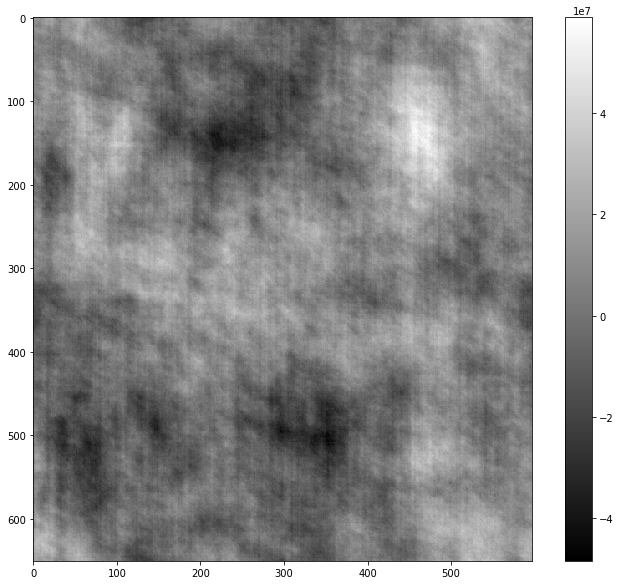

In [36]:
plt.figure(figsize=(12,10))

plt.imshow(np.fft.ifftshift(density_real),cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(12,10))

plt.imshow(np.fft.ifftshift(np.abs(mask_rb)),cmap='gray')
plt.colorbar()
plt.show()